<a href="https://colab.research.google.com/github/410650377/introduction-to-Computers/blob/main/%E3%80%8CLecture_3_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Investment Management (L03): Quantitative Asset Pricing Laboratory**
### Author: I-Chan Chiu

## Overview
In this comprehensive laboratory, we will bridge the gap between Asset Pricing Theory and Empirical Practice.
We will move from the theoretical **Dividend Discount Model (DDM)** to **Factor Testing** using real market data.

**Learning Objectives:**
1.  **Valuation Theory:** Understand how Discount Rates ($r$) drive prices using DDM simulation.
2.  **Signal Engineering:** Construct and handle financial signals (Value, Size, Momentum) properly.
3.  **Portfolio Sorting:** Master the academic standard for testing anomalies (Quantile Analysis).
4.  **Factor Attribution:** Dissect returns using CAPM, FF3, and FF5 models.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from scipy import stats

# --- Plotting Setup ---
# Setting fonts to avoid issues with negative signs or non-ASCII characters
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries loaded & plotting style set.")

Libraries loaded & plotting style set.


## Module 1: The Dividend Discount Model (DDM)

Before analyzing big data, let's build intuition with a simulation.
The **Gordon Growth Model** states:
$$P_0 = \frac{D_1}{r - g}$$

Rearranging for Expected Return ($r$):
$$r = \frac{D_1}{P_0} + g$$

**Key Insight:**
For a fixed cash flow ($D_1, g$), a **Lower Price** implies a **Higher Expected Return** ($r$).
This is the theoretical foundation of the **Value Premium**.

In [ ]:
def calculate_ddm_price(d1, r, g):
    """
    Calculates price based on Gordon Growth Model.
    Returns NaN if r <= g (model breakdown).
    """
    if r <= g:
        return np.nan
    return d1 / (r - g)

print(f"Test: D1=2, r=10%, g=3% -> Price = ${calculate_ddm_price(2,0.1,0.03):.4f}")

Test: D1=2, r=10%, g=3% -> Price = $28.5714


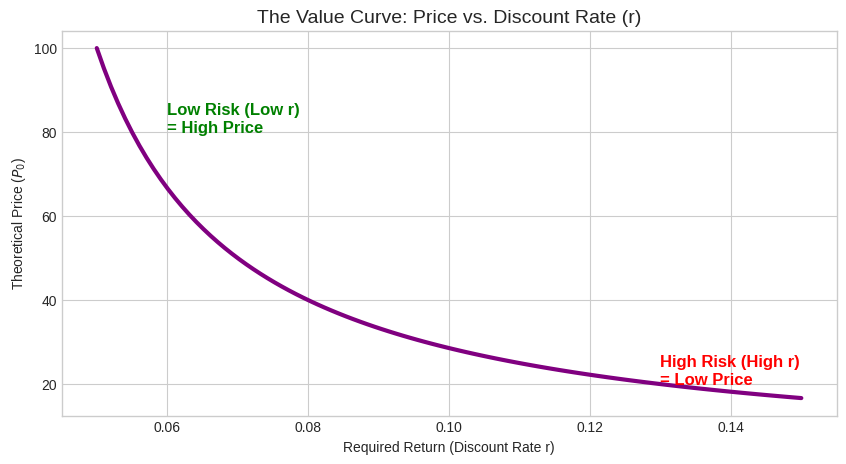

In [ ]:
# Simulate: How does Price change as Discount Rate (r) increases?
r_values =np.linspace(0.05,0.15,100)  # Rates from 5% to 15%
prices =[calculate_ddm_price(d1=2,r=r,g=0.03)for r in r_values]

plt.figure(figsize=(10, 5))
plt.plot(r_values, prices, color='purple', linewidth=3)
plt.title("The Value Curve: Price vs. Discount Rate (r)", fontsize=14)
plt.xlabel("Required Return (Discount Rate r)")
plt.ylabel("Theoretical Price ($P_0$)")
plt.grid(True)

# Add annotations for intuition
plt.text(0.06, 80, "Low Risk (Low r)\n= High Price", fontsize=12, color='green', fontweight='bold')
plt.text(0.13, 20, "High Risk (High r)\n= Low Price", fontsize=12, color='red', fontweight='bold')
plt.show()

### 🧠 Student Exercise: Duration Risk
**Objective:** Compare how "Value" vs "Growth" stocks react to a rate hike.

**Scenario:**
1.  **Value Stock:** High Dividend ($5), Low Growth (1%).

2.  **Growth Stock:** Low Dividend ($1), High Growth (4%).

3.  **Shock:** Discount Rate ($r$) increases from **6% to 7%**.

**Task:** Calculate the percentage price drop for both stocks.

In [ ]:
# === 🧠 STUDENT EXERCISE ===
# Write your code here to calculate the % drop for both stocks

r_old = 0.06
r_new = 0.07

# Value Stock 成長股的定義:
val_p_old =calculate_ddm_price(d1=5,r=r_old,g=0.01)
val_p_new =calculate_ddm_price(d1=5,r=r_new,g=0.01)
val_drop =(val_p_new-val_p_old)/val_p_old

# Growth Stock
gro_p_old =calculate_ddm_price(d1=1,r=r_old,g=0.04)
gro_p_new =calculate_ddm_price(d1=1,r=r_new,g=0.04)
gro_drop =(gro_p_new-gro_p_old)/gro_p_old

In [ ]:
print(f"Value Stock Price Drop:  {val_drop:.2%}")
print(f"Growth Stock Price Drop: {gro_drop:.2%}")

Value Stock Price Drop:  -16.67%
Growth Stock Price Drop: -33.33%


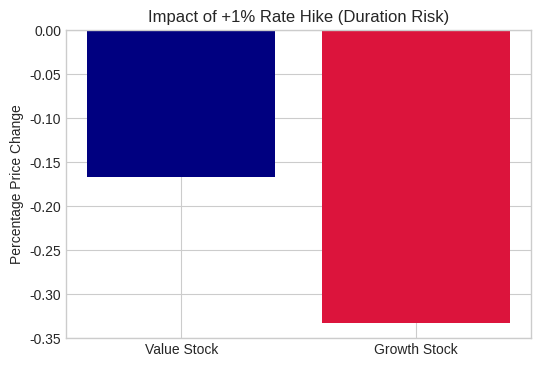

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(['Value Stock', 'Growth Stock'], [val_drop, gro_drop], color=['navy', 'crimson'])
plt.title("Impact of +1% Rate Hike (Duration Risk)")
plt.ylabel("Percentage Price Change")
plt.show()

 ## Module 2: Signal Engineering

We will construct three distinct signals to test anomalies:
1.  **Value (BM):** Book-to-Market Ratio ($1/PBR$).
2.  **Size (LogME):** Log of Market Cap.
3.  **Momentum (Mom):** Past 6-month returns.

**Crucial Step:** We must **LAG** our signals by 1 month to avoid **Look-ahead Bias**.

### 📂 Data Upload
Please upload the `data.zip` file containing:
1.  `twstock_monthly_2005_2024.csv` (Stock Data)
2.  `tw_ff_factors.csv` (Fama-French Factors)

In [ ]:
# --- Interactive File Upload ---
# This widget works specifically in Google Colab.
# If running locally, simply ensure 'data.zip' is in the same directory.

try:
    from google.colab import files
    print("Please upload your 'data.zip' file:")
    uploaded = files.upload()
    print("Upload successful.")
except ImportError:
    print("Not running in Google Colab. Checking local directory...")
    if os.path.exists('data.zip'):
        print("Local 'data.zip' found.")
    else:
        print("⚠️ Warning: 'data.zip' not found in local directory.")

Please upload your 'data.zip' file:


Saving data.zip to data (5).zip
Upload successful.


In [ ]:
# Unzip the uploaded file
if os.path.exists('data.zip'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("✅ Data unzipped successfully.")
else:
    print("❌ Error: Please upload 'data.zip' first.")

# Load the datasets
try:
    # 1. Stock Data
    stock_df = pd.read_csv("twstock_monthly_2005_2024.csv", parse_dates=['date'])
    # 2. Factor Data (Fama-French)
    factor_df = pd.read_csv("tw_ff_factors.csv", parse_dates=['date'])

    print(f"Stock Data Loaded: {stock_df.shape[0]} rows")
    print(f"Factor Data Loaded: {factor_df.shape[0]} rows")

except FileNotFoundError as e:
    print(f"❌ File not found: {e}")

✅ Data unzipped successfully.
Stock Data Loaded: 211732 rows
Factor Data Loaded: 322 rows


In [ ]:
from pandas.tseries.offsets import MonthEnd

# 1. Align date formats
# Force both stock_df and factor_df dates to the last day of each month.
# This ensures that whether the original dates are 1/1, 1/31, or 1/25,
# they will all be aligned to the same date (e.g., 2005-01-31).

stock_df['date'] =pd.to_datetime(stock_df['date'])+MonthEnd(0)
factor_df['date'] =pd.to_datetime(factor_df['date'])+MonthEnd(0)


In [ ]:
stock_df.head()

,date,stock_code,stock_name,RET,TOR,ME,PER,PBR,PRR,DY,HLD
0,2005-01-31,1101,台泥,-0.038277,0.091584,0.00389,19.78,1.04,1.98,1.68,0.129187
1,2005-02-28,1101,台泥,0.004975,0.050366,0.00376,19.88,1.05,1.99,1.67,0.059701
2,2005-03-31,1101,台泥,-0.094060,0.106246,0.00351,18.01,0.95,1.80,1.84,0.180693
3,2005-04-30,1101,台泥,0.038253,0.059723,0.00376,18.70,0.98,1.87,1.77,0.095628
4,2005-05-31,1101,台泥,-0.060526,0.057039,0.00341,17.57,0.92,1.76,1.89,0.071053


In [ ]:
factor_df.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,MOM,RF
0,1999-01-31,-0.069149,-0.020239,-0.021888,-0.062740,0.022126,-0.088878,0.0540
1,1999-02-28,0.047145,-0.054808,-0.004235,-0.024442,0.050014,-0.061353,0.0505
2,1999-03-31,0.082766,0.006151,0.040417,0.018287,0.012246,0.014906,0.0505
3,1999-04-30,0.065397,-0.006219,0.047215,-0.002581,0.026643,-0.001681,0.0500
4,1999-05-31,-0.018586,-0.029572,-0.138730,0.070672,-0.084869,0.136957,0.0500


In [ ]:
# 2. Perform merge
# Now that dates are aligned, it is safe to merge.
df =pd.merge(stock_df,factor_df,on='date',how='left')

# Check merge result: if Mkt-RF is all NaN, the merge likely failed.
if df['Mkt-RF'].isnull().all():
    print("⚠️ Warning: Merge failed — dates did not match at all! Please verify the original date format.")
else:
    print(f"✅ Merge successful! Number of rows: {len(df)}")

✅ Merge successful! Number of rows: 211732


In [ ]:
# 3. Calculate excess returns
df['ExRet'] =df['RET']-df['RF']

# 4. Basic cleaning
# Remove rows with missing values
df_clean =df.dropna(subset=['RET','ExRet','ME'])

# Ensure stock code is a string
df_clean['stock_code'] =df_clean['stock_code'].astype(str)

print("Data processing completed.")
df_clean[['date', 'stock_code', 'RET', 'RF', 'ExRet']].head()

Data processing completed.


/tmp/ipython-input-3581871749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['stock_code'] =df_clean['stock_code'].astype(str)


,date,stock_code,RET,RF,ExRet
0,2005-01-31,1101,-0.038277,0.01595,-0.054227
1,2005-02-28,1101,0.004975,0.01595,-0.010975
2,2005-03-31,1101,-0.094060,0.01690,-0.110960
3,2005-04-30,1101,0.038253,0.01690,0.021353
4,2005-05-31,1101,-0.060526,0.01690,-0.077426


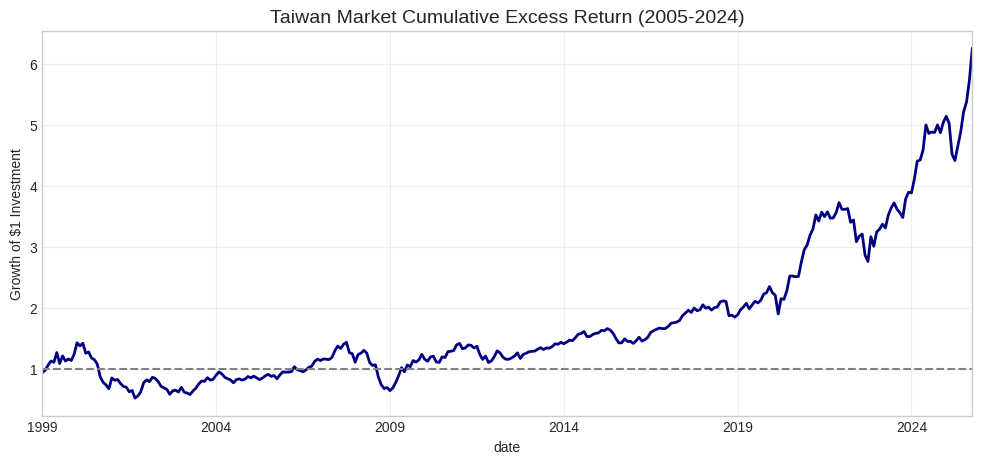

In [ ]:
# Visualize Market Cumulative Returns

market_cum_ret = (1 + factor_df.set_index('date')['Mkt-RF']).cumprod()

plt.figure(figsize=(12, 5))
market_cum_ret.plot(color='navy', linewidth=2)
plt.title("Taiwan Market Cumulative Excess Return (2005-2024)", fontsize=14)
plt.ylabel("Growth of $1 Investment")
plt.axhline(1, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 1. Value: Book-to-Market
df_clean['BM'] =1/df_clean['PBR']
# Handle negative equity (set to NaN)
df_clean.loc[df_clean['PBR']<= 0,'BM']=np.nan

# 2. Size: Log Market Cap
df_clean['LogME'] =np.log(df_clean['ME'])

# 3. Momentum: Rolling mean of past 6 months return
# Note: We use groupby to ensure rolling is done per stock
df_clean =df_clean.sort_values(['stock_code','date'])
df_clean['Mom_Raw'] =df_clean.groupby('stock_code')['RET'].transform(lambda x:x.rolling(6).mean())

/tmp/ipython-input-265250685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['BM'] =1/df_clean['PBR']
/tmp/ipython-input-265250685.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['LogME'] =np.log(df_clean['ME'])


In [ ]:
# LAG SIGNALS (Avoid Look-Ahead Bias)
# We use the signal known at time t-1 to predict return at time t

features = ['BM', 'LogME', 'Mom_Raw']

for col in features:
    df_clean[f'{col}_Lag'] =df_clean.groupby('stock_code')[col].shift(1)

# Remove rows with NaNs in these new lagged columns
df_signals = df_clean.dropna(subset=[f'{c}_Lag' for c in features] + ['ExRet', 'ME']).copy()

print(f"Signals Lagged. Final Dataset Size: {len(df_signals)} rows")

Signals Lagged. Final Dataset Size: 194908 rows


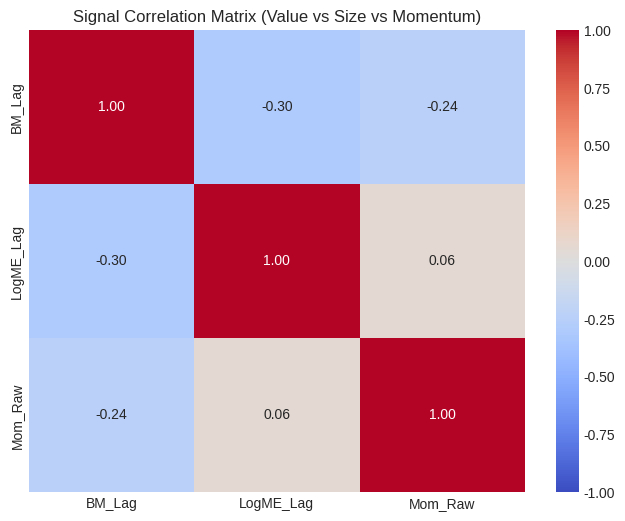

In [ ]:
# It is important to check if signals are correlated.
# Low correlation means they offer distinct information.

corr_matrix =df_signals[['BM_Lag','LogME_Lag','Mom_Raw']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Signal Correlation Matrix (Value vs Size vs Momentum)")
plt.show()

## Module 3: Portfolio Sorting Mechanics

We define a reusable function `get_quantile_stats`.
This function performs the core "Backtesting" logic:
1.  **Sort:** Divide stocks into N buckets (Quantiles) based on a signal.
2.  **Weight:** Calculate weights (Equal or Value-Weighted).
3.  **Return:** Compute the weighted average return for each bucket.

In [ ]:
def get_quantile_stats(df, signal_col, n_buckets=5, weighting='EW'):
    """
    Sorts stocks into n_buckets and calculates portfolio returns.
    weighting: 'VW' (Value Weighted) or 'EW' (Equal Weighted)
    """
    temp = df.copy()

    # 1. Assign Group (0 to n-1)
    # qcut divides data into equal-sized buckets per date
    temp['group'] =temp.groupby('date')[signal_col].transform(
        lambda x: pd.qcut(x, n_buckets, labels=False, duplicates='drop')
    )

    # 2. Calculate Weights
    if weighting == 'VW':#me/sum(me)ofgroup
        temp['w'] =temp['ME']/temp.groupby(['date','group'])['ME'].transform('sum')
    else: # EW
        temp['w'] =1.0/temp.groupby(['date','group'])['stock_code'].transform('count')

    # 3. Calculate Contribution
    temp['ret_contribution'] =temp['w']*temp['ExRet']

    # 4. Aggregate by Date and Group
    port_ret = temp.groupby(['date', 'group'])['ret_contribution'].sum().reset_index()

    # 5. Statistics (Annualized)
    stats = port_ret.groupby('group')['ret_contribution'].agg(['mean', 'std', 'count'])
    stats['Ann_Ret'] = stats['mean'] * 12
    stats['Ann_Vol'] = stats['std'] * (12**0.5)
    stats['Sharpe'] = stats['Ann_Ret'] / stats['Ann_Vol']

    return port_ret, stats

In [ ]:
# Let's test our function with the Value Signal (BM_Lag)
port_monthly, port_stats =get_quantile_stats(df_signals,'BM_Lag',n_buckets=5,weighting='EW')

print("--- Value Strategy Statistics (Q0=Growth, Q4=Value) ---")
print(port_stats)

--- Value Strategy Statistics (Q0=Growth, Q4=Value) ---
           mean       std  count   Ann_Ret   Ann_Vol    Sharpe
group                                                         
0     -0.004238  0.061178    237 -0.050853  0.211928 -0.239953
1     -0.003769  0.060609    234 -0.045229  0.209957 -0.215420
2     -0.002129  0.059740    234 -0.025553  0.206947 -0.123477
3     -0.001122  0.063188    234 -0.013467  0.218890 -0.061522
4      0.002056  0.071489    237  0.024673  0.247645  0.099630


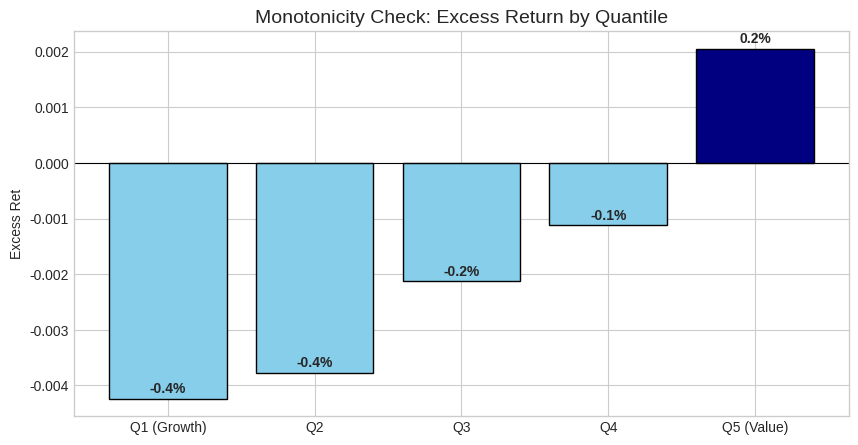

In [ ]:
# 1. Prepare Data for Plotting (Pivot Table)
# We need columns: Q0, Q1, Q2, Q3, Q4 (or Q1-Q5 in business terms)
port_pivot = port_monthly.pivot(index='date', columns='group', values='ret_contribution')
port_pivot.columns = ['Q1 (Growth)', 'Q2', 'Q3', 'Q4', 'Q5 (Value)']

# 2. Bar Chart: Average Annualized Return (The "Staircase" Test)
# Theoretical Expectation: Returns should increase from Q1 to Q5
plt.figure(figsize=(10, 5))

# Color logic: Highlight the Value portfolio (Q5)
colors = ['skyblue'] * 5
colors[-1] = 'navy'

plt.bar(port_pivot.columns, port_stats['mean'], color=colors, edgecolor='black')
plt.title("Monotonicity Check: Excess Return by Quantile", fontsize=14)
plt.ylabel("Excess Ret")
plt.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for i, v in enumerate(port_stats['mean']):
    plt.text(i, v+0.0001 , f"{v:.1%}", ha='center', fontweight='bold')

plt.show()

/tmp/ipython-input-1805417054.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mkt_cum = mkt_cum.reindex(cum_ret.index).fillna(method='ffill')


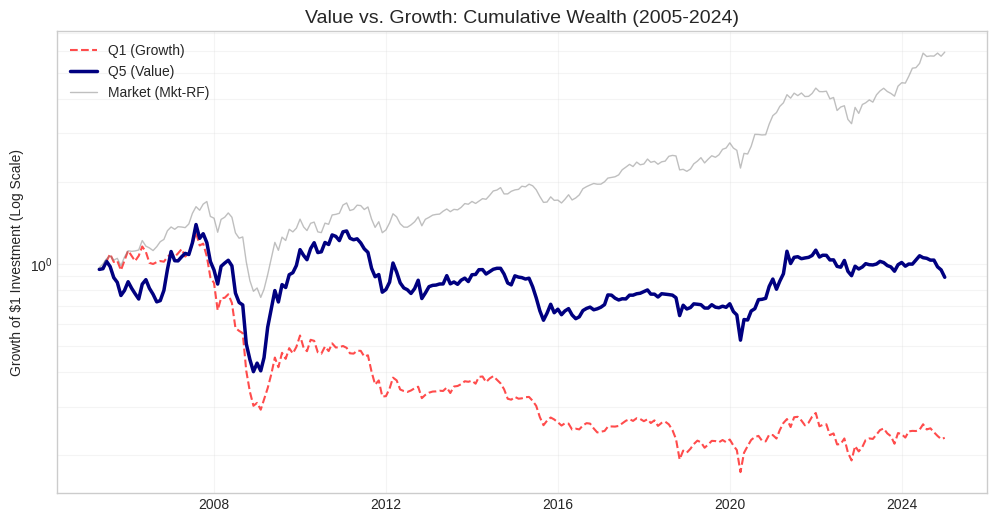

In [ ]:
# 3. Equity Curve (Cumulative Return)
# We compare the "Top Bucket" (Value) vs "Bottom Bucket" (Growth) vs "Market"

# Calculate cumulative returns (Growth of $1)
cum_ret =(1+port_pivot[['Q1 (Growth)', 'Q5 (Value)']]).cumprod()

plt.figure(figsize=(12, 6))

# Plot Q1 (Growth)
plt.plot(cum_ret['Q1 (Growth)'], label='Q1 (Growth)', linestyle='--', color='red', alpha=0.7)

# Plot Q5 (Value)
plt.plot(cum_ret['Q5 (Value)'], label='Q5 (Value)', color='navy', linewidth=2.5)

mkt_series = df_signals[['date', 'Mkt-RF']].drop_duplicates().set_index('date')['Mkt-RF']

mkt_series = mkt_series.sort_index()

mkt_cum =(1+mkt_series).cumprod()
mkt_cum = mkt_cum.reindex(cum_ret.index).fillna(method='ffill')

plt.plot(mkt_cum, label='Market (Mkt-RF)', color='gray', alpha=0.5, linewidth=1)

plt.title("Value vs. Growth: Cumulative Wealth (2005-2024)", fontsize=14)
plt.ylabel("Growth of $1 Investment (Log Scale)")
plt.yscale('log') # Log scale helps visualize long-term compounding
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

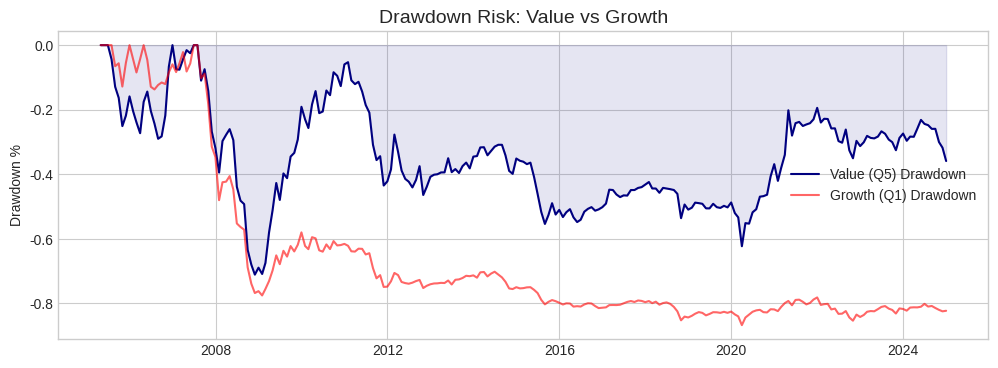

In [ ]:
# 4. Drawdown Analysis
# Value investing can be painful. Let's see the drawdowns.
def calculate_drawdown(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown

dd_q5 =calculate_drawdown(cum_ret['Q5 (Value)'])
dd_q1 =calculate_drawdown(cum_ret['Q1 (Growth)'])

plt.figure(figsize=(12, 4))
plt.plot(dd_q5, label='Value (Q5) Drawdown', color='navy')
plt.plot(dd_q1, label='Growth (Q1) Drawdown', color='red', alpha=0.6)
plt.fill_between(dd_q5.index, dd_q5, 0, color='navy', alpha=0.1)
plt.title("Drawdown Risk: Value vs Growth", fontsize=14)
plt.ylabel("Drawdown %")
plt.legend()
plt.show()

## Module 4: Factor Attribution (The Alpha Test)

Is the outperformance of Q5 (Value) due to **Manager Skill (Alpha)** or just **Risk Exposure (Beta)**?
We will run regressions on the **Long-Short Spread** (Q5 - Q1).

**The Models:**
1.  **CAPM:** $R_{Spread} = \alpha + \beta_{mkt}(R_m - R_f)$
2.  **Fama-French 5-Factor (FF5):** $R_{Spread} = \alpha + \beta_m Mkt + \beta_s SMB + \beta_h HML + \beta_r RMW + \beta_c CMA$

**Hypothesis:**
For a Value strategy, we expect a high positive loading on **HML**. If HML explains the return, $\alpha$ should drop to zero.

In [ ]:
#mean return
port_pivot.head()

,Q1 (Growth),Q2,Q3,Q4,Q5 (Value)
date,,,,,
2005-04-30,-0.046399,NaN,NaN,NaN,-0.046399
2005-05-31,0.005895,NaN,NaN,NaN,0.005895
2005-06-30,0.064823,NaN,NaN,NaN,0.064823
2005-07-31,0.063310,0.016499,-0.004094,-0.003626,-0.043645
2005-08-31,-0.065258,-0.080579,-0.073624,-0.074170,-0.089473


In [ ]:
# 1. Create the Spread Return (Long Q5, Short Q1)
# Note: This is a zero-cost portfolio (conceptually)
spread_ret =port_pivot['Q5 (Value)']-port_pivot['Q1 (Growth)']
spread_ret.name ='Spread_Ret'
# 2. Calculate Excess Returns
# 2. Merge with Factor Data
# Ensure dates align perfectly
reg_data = pd.merge(spread_ret, factor_df.set_index('date'), left_index=True, right_index=True).dropna()

print(f"Regression Data Ready. Months: {len(reg_data)}")

Regression Data Ready. Months: 237


In [ ]:
# Model 1: CAPM
X_capm =sm.add_constant(reg_data[['Mkt-RF']])
model_capm =sm.OLS(reg_data['Spread_Ret'],X_capm).fit()

# Model 2: Fama-French 5-Factor
# We include all 5 factors to see true risk-adjusted performance
X_ff5 =sm.add_constant(reg_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
model_ff5 =sm.OLS(reg_data['Spread_Ret'],X_ff5).fit()

# --- Display Key Results ---
print("=== CAPM Results (Value Strategy) ===")
print(f"Alpha (Monthly): {model_capm.params['const']:.4f}")
print(f"Alpha (t-stat):  {model_capm.tvalues['const']:.2f}")
print(f"Market Beta:     {model_capm.params['Mkt-RF']:.4f}")

print("\n=== FF5 Results (Value Strategy) ===")
print(f"Alpha (Monthly): {model_ff5.params['const']:.4f}")
print(f"Alpha (t-stat):  {model_ff5.tvalues['const']:.2f}")
print(f"HML Beta:        {model_ff5.params['HML']:.4f}")

=== CAPM Results (Value Strategy) ===
Alpha (Monthly): 0.0055
Alpha (t-stat):  2.18
Market Beta:     0.0859

=== FF5 Results (Value Strategy) ===
Alpha (Monthly): 0.0053
Alpha (t-stat):  2.83
HML Beta:        0.5982


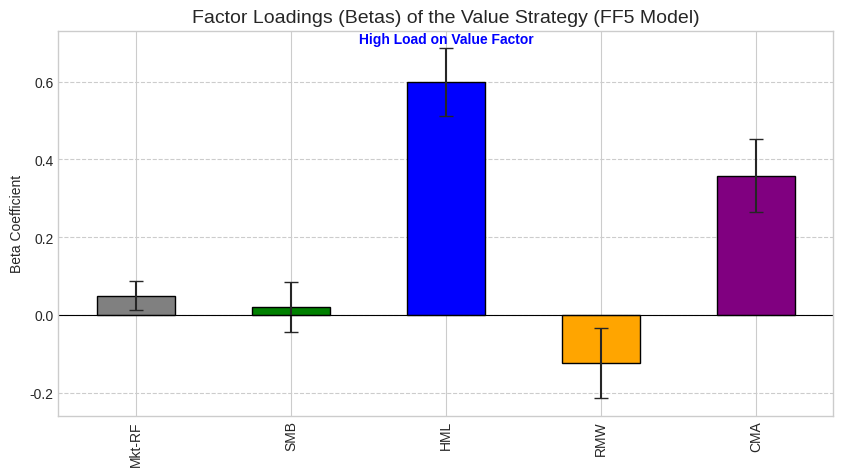

In [ ]:
# Visualize the "Risk Profile" of our strategy
betas =model_ff5.params.drop('const')
errors =model_ff5.bse.drop('const')

plt.figure(figsize=(10, 5))
betas.plot(kind='bar', yerr=errors, capsize=5, color=['gray', 'green', 'blue', 'orange', 'purple'], edgecolor='black')
plt.title("Factor Loadings (Betas) of the Value Strategy (FF5 Model)", fontsize=14)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Beta Coefficient")
plt.grid(axis='y', linestyle='--')

# Add interpretation text
plt.text(2, betas['HML'] + 0.1, "High Load on Value Factor", ha='center', color='blue', fontweight='bold')
plt.show()

**Interpretation:**
You should see a large positive bar for **HML**. This confirms that our simple B/M sort is capturing the same "Value Risk" defined by Fama and French.
If the FF5 Alpha is close to zero (t-stat < 2), it means the strategy **does not** generate abnormal returns after controlling for known risks.

## STUDENT EXERCISE: Please try another anomaly. For example, size, and test the alpha

In [ ]:
#size=log_return

In [ ]:
# Step 1 > Let's test our function with size signal
## Let's test our function with the Value Signal (BM_Lag)
port_monthly, port_stats =get_quantile_stats(df_signals,'LogME_Lag',n_buckets=5,weighting='EW')

print("--- Value Strategy Statistics (Q0=Small, Q4=Big) ---")
print(port_stats)

--- Value Strategy Statistics (Q0=Small, Q4=Big) ---
           mean       std  count   Ann_Ret   Ann_Vol    Sharpe
group                                                         
0      0.001583  0.068425    237  0.019002  0.237030  0.080167
1     -0.001540  0.064372    234 -0.018484  0.222991 -0.082891
2     -0.002611  0.062559    234 -0.031334  0.216711 -0.144588
3     -0.003023  0.062167    234 -0.036278  0.215354 -0.168456
4     -0.004090  0.056710    237 -0.049082  0.196450 -0.249845


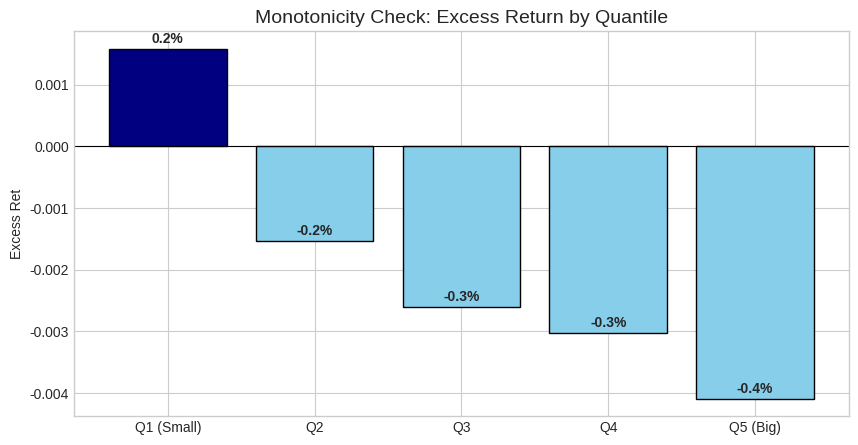

In [ ]:
# Step 2 > Plot Excess Return Data
# 1. Prepare Data for Plotting (Pivot Table)
# We need columns: Q0, Q1, Q2, Q3, Q4 (or Q1-Q5 in business terms)
port_pivot = port_monthly.pivot(index='date', columns='group', values='ret_contribution')
port_pivot.columns = ['Q1 (Small)', 'Q2', 'Q3', 'Q4', 'Q5 (Big)']

# 2. Bar Chart: Average Annualized Return (The "Staircase" Test)
# Theoretical Expectation: Returns should increase from Q1 to Q5
plt.figure(figsize=(10, 5))

# Color logic: Highlight the Value portfolio (Q5)
colors = ['skyblue'] * 5
colors[0] = 'navy'

plt.bar(port_pivot.columns, port_stats['mean'], color=colors, edgecolor='black')
plt.title("Monotonicity Check: Excess Return by Quantile", fontsize=14)
plt.ylabel("Excess Ret")
plt.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for i, v in enumerate(port_stats['mean']):
    plt.text(i, v+0.0001 , f"{v:.1%}", ha='center', fontweight='bold')

plt.show()

/tmp/ipython-input-1908362764.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mkt_cum = mkt_cum.reindex(cum_ret.index).fillna(method='ffill')


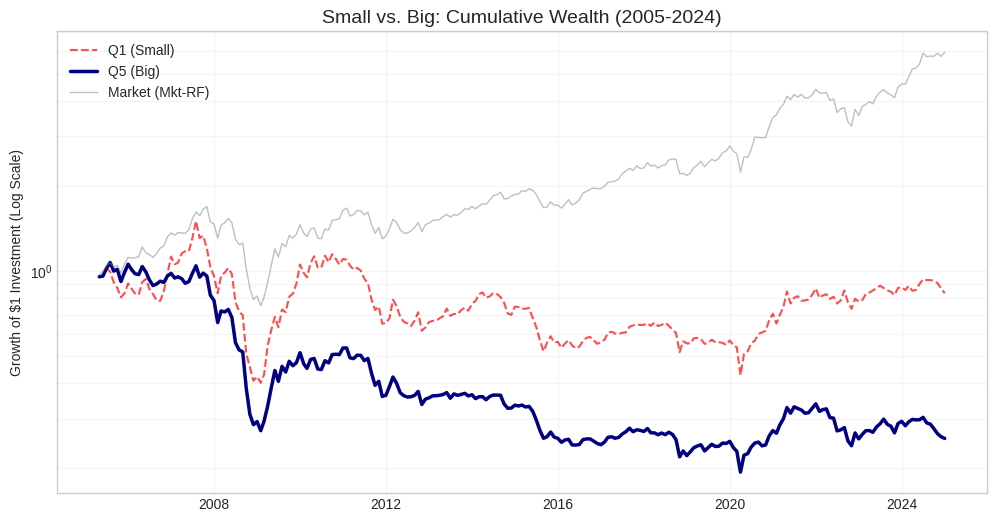

In [ ]:
# Step 3 > Draft Equity Curve
# 3. Equity Curve (Cumulative Return)
# We compare the "Top Bucket" (Big) vs "Bottom Bucket" (Small) vs "Market"

# Calculate cumulative returns (Growth of $1)
cum_ret =(1+port_pivot[['Q1 (Small)', 'Q5 (Big)']]).cumprod()

plt.figure(figsize=(12, 6))

# Plot Q1 (Growth)
plt.plot(cum_ret['Q1 (Small)'], label='Q1 (Small)', linestyle='--', color='red', alpha=0.7)

# Plot Q5 (Value)
plt.plot(cum_ret['Q5 (Big)'], label='Q5 (Big)', color='navy', linewidth=2.5)

mkt_series = df_signals[['date', 'Mkt-RF']].drop_duplicates().set_index('date')['Mkt-RF']

mkt_series = mkt_series.sort_index()

mkt_cum =(1+mkt_series).cumprod()
mkt_cum = mkt_cum.reindex(cum_ret.index).fillna(method='ffill')

plt.plot(mkt_cum, label='Market (Mkt-RF)', color='gray', alpha=0.5, linewidth=1)

plt.title("Small vs. Big: Cumulative Wealth (2005-2024)", fontsize=14)
plt.ylabel("Growth of $1 Investment (Log Scale)")
plt.yscale('log') # Log scale helps visualize long-term compounding
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
# Step 4 > Alpha Test
# 1. Create the Spread Return (Long Q5, Short Q1)
# Note: This is a zero-cost portfolio (conceptually)
spread_ret =port_pivot['Q1 (Small)']-port_pivot['Q5 (Big)']
spread_ret.name ='Spread_Ret'
# 2. Calculate Excess Returns
# 2. Merge with Factor Data
# Ensure dates align perfectly
reg_data = pd.merge(spread_ret, factor_df.set_index('date'), left_index=True, right_index=True).dropna()

print(f"Regression Data Ready. Months: {len(reg_data)}")


Regression Data Ready. Months: 237


In [ ]:
# Model 1: CAPM
X_capm =sm.add_constant(reg_data[['Mkt-RF']])
model_capm =sm.OLS(reg_data['Spread_Ret'],X_capm).fit()

# Model 2: Fama-French 5-Factor
# We include all 5 factors to see true risk-adjusted performance
X_ff5 =sm.add_constant(reg_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
model_ff5 =sm.OLS(reg_data['Spread_Ret'],X_ff5).fit()

# --- Display Key Results ---
print("=== CAPM Results (Value Strategy) ===")
print(f"Alpha (Monthly): {model_capm.params['const']:.4f}")
print(f"Alpha (t-stat):  {model_capm.tvalues['const']:.2f}")
print(f"Market Beta:     {model_capm.params['Mkt-RF']:.4f}")

print("\n=== FF5 Results (Value Strategy) ===")
print(f"Alpha (Monthly): {model_ff5.params['const']:.4f}")
print(f"Alpha (t-stat):  {model_ff5.tvalues['const']:.2f}")
print(f"HML Beta:        {model_ff5.params['HML']:.4f}")

=== CAPM Results (Value Strategy) ===
Alpha (Monthly): 0.0053
Alpha (t-stat):  2.45
Market Beta:     0.0418

=== FF5 Results (Value Strategy) ===
Alpha (Monthly): 0.0027
Alpha (t-stat):  1.83
HML Beta:        0.2575


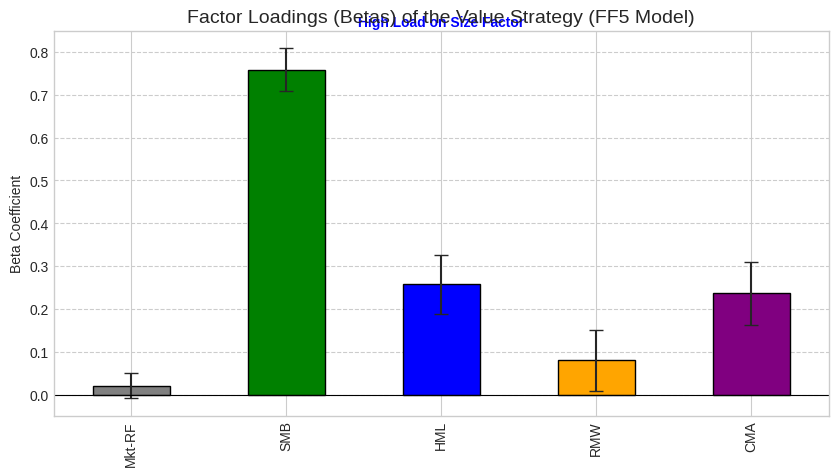

In [ ]:
# Step 5 > Factor Loading Visualization
# Visualize the "Risk Profile" of our strategy
betas =model_ff5.params.drop('const')
errors =model_ff5.bse.drop('const')

plt.figure(figsize=(10, 5))
betas.plot(kind='bar', yerr=errors, capsize=5, color=['gray', 'green', 'blue', 'orange', 'purple'], edgecolor='black')
plt.title("Factor Loadings (Betas) of the Size Strategy (FF5 Model)", fontsize=14)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Beta Coefficient")
plt.grid(axis='y', linestyle='--')

# Add interpretation text
plt.text(2, betas['SMB'] + 0.1, "High Load on Size Factor", ha='center', color='blue', fontweight='bold')
plt.show()

## Conclusion & Key Takeaways

In this lecture, we successfully built a complete quantitative research pipeline:

1.  **Valuation:** We used the DDM simulation to understand the theoretical link between Price and Returns.
2.  **Backtesting:** We implemented a robust **Quantile Sort** engine, verifying the monotonicity of the Value Premium.
3.  **Factor Models:** We used **FF5 regressions** to show that the Value strategy's returns are largely explained by the HML factor (Risk), not necessarily pure Alpha (Skill).